In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Checagem por campos nulos no dataframe

In [3]:
df.isnull().any()

age                         False
anaemia                     False
creatinine_phosphokinase    False
diabetes                    False
ejection_fraction           False
high_blood_pressure         False
platelets                   False
serum_creatinine            False
serum_sodium                False
sex                         False
smoking                     False
time                        False
DEATH_EVENT                 False
dtype: bool

### TODO: Checagem por outliers (spurious data)

In [4]:
%matplotlib inline

#plot = sns.pairplot(df, hue="DEATH_EVENT")
#plot.savefig('heart_scatter.png', dpi=100, bbox_inches='tight')

<AxesSubplot:>

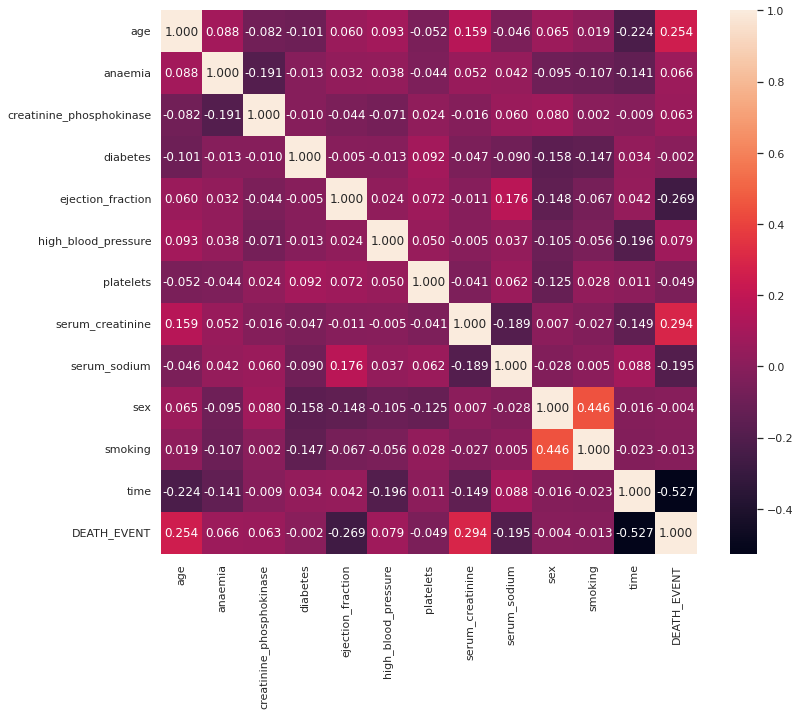

In [5]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df.corr(), annot=True, fmt='.3f')

### Numero de labels 'DEATH' / total de labels

In [6]:
print(sum(df['DEATH_EVENT']), len(df))

96 299


### Criando um dataframe parcial apenas com os dados mais correlacionados com o resultado

edit: Existe uma consideração a ser feita do tempo ser efeito e não causa... (TODO)

In [7]:
top_corr = df[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']]
top_corr.head()

,age,ejection_fraction,serum_creatinine,serum_sodium,time
0,75.0,20,1.9,130,4
1,55.0,38,1.1,136,6
2,65.0,20,1.3,129,7
3,50.0,20,1.9,137,7
4,65.0,20,2.7,116,8


### Checando se os tamanhos dos dataframes batem

In [8]:
x = top_corr
x.shape

(299, 5)

In [9]:
y = df['DEATH_EVENT']
y.shape

(299,)

### Usando SMOTE para balancear o dataset

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [10]:
oversample = SMOTE()
x_sm, y_sm = oversample.fit_resample(x, y)
#df_sm = x_sm.copy()
#df_sm['DEATH_EVENT'] = y_sm

x_sm_train, x_sm_test, y_sm_train, y_sm_test = train_test_split(x_sm, y_sm, test_size=0.33, random_state=42)

x_sm.shape

(406, 5)

### Treino e test sem SMOTE, amostragem para manter positivos e negativos balanceados no treinamento

In [11]:
x_train = []
x_test = []
y_train = []
y_test = []

x, y = shuffle(x, y, random_state=42)
x = x.values
y = y.values

count_positives = 0
count_negatives = 0
for i in range(len(x)):
    if y[i] == 0:
        if count_negatives < 48:
            x_train.append(x[i])
            y_train.append(y[i])
            count_negatives += 1
        else:
            x_test.append(x[i])
            y_test.append(y[i])
    
    else:
        if count_positives < 48:
            x_train.append(x[i])
            y_train.append(y[i])
            count_positives += 1
        else:
            x_test.append(x[i])
            y_test.append(y[i])

In [12]:
# Scaling (normalizing) X
scaler=StandardScaler()
sm_scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_sm_train = sm_scaler.fit_transform(x_sm_train)
x_sm_test = sm_scaler.transform(x_sm_test)

In [13]:
models = {"KNN": KNeighborsClassifier(),
          "LogisticReg": LogisticRegression(),
          "RandomForest": RandomForestClassifier(),
          "GradientBoost": GradientBoostingClassifier()
          #"XGBoost": XGBClassifier()
         }

scores = {}
for name, model in models.items():
        model.fit(x_train, y_train)
        scores[name] = [model.score(x_test, y_test)]
        
print(scores)

{'KNN': [0.7586206896551724], 'LogisticReg': [0.7733990147783252], 'RandomForest': [0.8275862068965517], 'GradientBoost': [0.7980295566502463]}


In [14]:
for name, model in models.items():
        model.fit(x_sm_train, y_sm_train)
        scores[name].append(model.score(x_sm_test, y_sm_test))
        
compare_df = pd.DataFrame.from_dict(scores, orient='index')
compare_df.reset_index(level=0, inplace=True)
compare_df.columns = ['Method', 'Raw', 'SMOTE']
compare_df

,Method,Raw,SMOTE
0,KNN,0.758621,0.835821
1,LogisticReg,0.773399,0.798507
2,RandomForest,0.827586,0.858209
3,GradientBoost,0.798030,0.820896


### Comparação de resultado parcial usando SMOTE

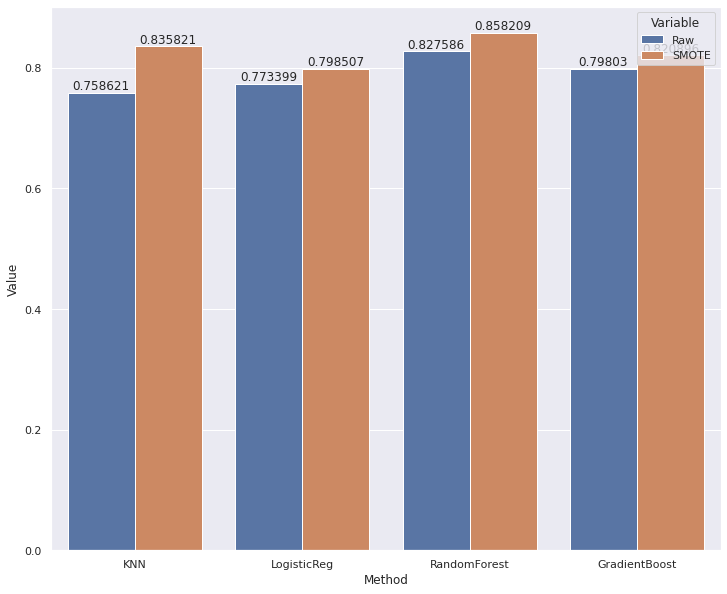

In [15]:
tidy = compare_df.melt(id_vars='Method').rename(columns=str.title)
ax = sns.barplot(x='Method', y='Value', hue='Variable', data=tidy)

for container in ax.containers:
    ax.bar_label(container)

### Testando GridSearch dos parametros para cada um dos metodos

In [16]:
# parametros p/ gridsearch

lr_params = [
    {"solver": ["lbfgs"], 'penalty': ['l2'], 'C':[0.1, 0.25, 0.5, 0.75, 1.0]},
    {"solver": ["liblinear"], 'penalty': ['l1', 'l2'], 'C':[0.1, 0.25, 0.5, 0.75, 1.0]},
]

rforest_params = [
    {'n_estimators': [50, 100, 150, 250, 500, 1000], 
     'criterion': ['gini', 'entropy'],
     'max_features': ['auto', 'sqrt', 'log2'],
     "max_depth":[9, 12, 18],
     "min_samples_split": [2, 4, 6]},
]

knn_params = [
    {'n_neighbors': [1,2,3,4,5,6,7,8,9], 
     'weights': ['uniform', 'distance'], 
     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
]

gb_params = [
    {"n_estimators" : [1000, 2500],
      "subsample" : [0.5, 1.0],
      "max_depth":[9, 18],
      "learning_rate" : [0.025, 0.75]}
]

gridsearch_params = {"KNN": knn_params,
          "LogisticReg": lr_params,
          "RandomForest": rforest_params,
          "GradientBoost": gb_params
         }

score_targets = ["recall"]

In [17]:
best_param_scores = []

def test_method(key):
    for score in score_targets:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(models[key], gridsearch_params[key], scoring="%s_macro" % score, n_jobs=-1, refit=True)
        clf.fit(x_sm_train, y_sm_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_["mean_test_score"]
        stds = clf.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_sm_test, clf.predict(x_sm_test)
        print(classification_report(y_true, y_pred, digits=4))
        print()
        
        print('final:', clf.best_estimator_.score(x_sm_test, y_sm_test))
        
        return clf.best_estimator_.score(x_sm_test, y_sm_test)

In [18]:
best_param_scores.append(test_method('KNN'))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}

Grid scores on development set:

0.820 (+/-0.046) for {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
0.820 (+/-0.046) for {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'distance'}
0.784 (+/-0.115) for {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}
0.820 (+/-0.046) for {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}
0.863 (+/-0.065) for {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
0.863 (+/-0.065) for {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
0.800 (+/-0.067) for {'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'uniform'}
0.844 (+/-0.062) for {'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}
0.832 (+/-0.075) for {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
0.848 (+/-0.073) for {'algorithm': 'auto', 'n_neighbors': 5, 'weight

In [19]:
best_param_scores.append(test_method('LogisticReg'))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

Grid scores on development set:

0.793 (+/-0.037) for {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.801 (+/-0.060) for {'C': 0.25, 'penalty': 'l2', 'solver': 'lbfgs'}
0.804 (+/-0.055) for {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
0.804 (+/-0.055) for {'C': 0.75, 'penalty': 'l2', 'solver': 'lbfgs'}
0.808 (+/-0.043) for {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.798 (+/-0.050) for {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.790 (+/-0.046) for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.798 (+/-0.039) for {'C': 0.25, 'penalty': 'l1', 'solver': 'liblinear'}
0.801 (+/-0.060) for {'C': 0.25, 'penalty': 'l2', 'solver': 'liblinear'}
0.794 (+/-0.049) for {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
0.801 (+/-0.060) for {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
0.797 (+/-0.051) for {'C': 0.75, 'penalty': 'l1', 'solver'

In [20]:
best_param_scores.append(test_method('RandomForest'))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}

Grid scores on development set:

0.884 (+/-0.086) for {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 50}
0.883 (+/-0.090) for {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
0.880 (+/-0.103) for {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 150}
0.887 (+/-0.094) for {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 250}
0.883 (+/-0.106) for {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500}
0.891 (+/-0.091) for {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 1000}
0.8

In [21]:
best_param_scores.append(test_method('GradientBoost'))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'learning_rate': 0.025, 'max_depth': 18, 'n_estimators': 1000, 'subsample': 0.5}

Grid scores on development set:

0.877 (+/-0.088) for {'learning_rate': 0.025, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.5}
0.838 (+/-0.101) for {'learning_rate': 0.025, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 1.0}
0.870 (+/-0.102) for {'learning_rate': 0.025, 'max_depth': 9, 'n_estimators': 2500, 'subsample': 0.5}
0.827 (+/-0.107) for {'learning_rate': 0.025, 'max_depth': 9, 'n_estimators': 2500, 'subsample': 1.0}
0.878 (+/-0.113) for {'learning_rate': 0.025, 'max_depth': 18, 'n_estimators': 1000, 'subsample': 0.5}
0.834 (+/-0.108) for {'learning_rate': 0.025, 'max_depth': 18, 'n_estimators': 1000, 'subsample': 1.0}
0.866 (+/-0.092) for {'learning_rate': 0.025, 'max_depth': 18, 'n_estimators': 2500, 'subsample': 0.5}
0.827 (+/-0.107) for {'learning_rate': 0.025, 'max_depth': 18, 'n_estimators': 250

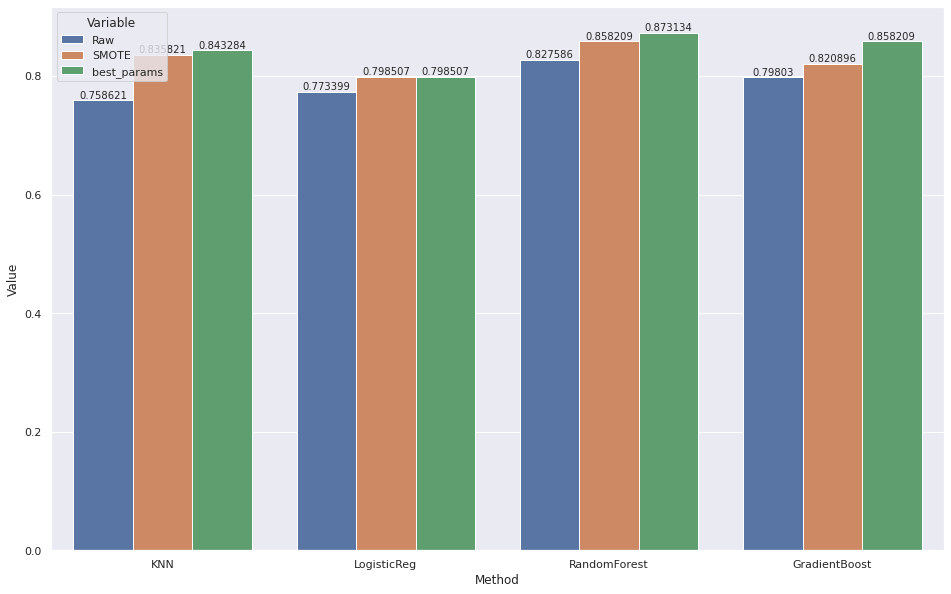

In [22]:
%matplotlib inline

plt.figure(figsize=(16,10))
compare_df['best_params'] = best_param_scores

tidy = compare_df.melt(id_vars='Method').rename(columns=str.title)
ax = sns.barplot(x='Method', y='Value', hue='Variable', data=tidy)

for container in ax.containers:
    ax.bar_label(container)

In [23]:
final_clf = RandomForestClassifier(criterion='gini', max_depth=18, max_features='sqrt', min_samples_split=2, n_estimators=150, random_state=42)
final_clf.fit(x_sm_train, y_sm_train)

print('basic score: ', final_clf.score(x_sm_test, y_sm_test))

y_true, y_pred = y_sm_test, final_clf.predict(x_sm_test)
print(classification_report(y_true, y_pred, digits=4))
print('f1 score: ', f1_score(y_true, y_pred))

basic score:  0.8731343283582089
              precision    recall  f1-score   support

           0     0.8571    0.8710    0.8640        62
           1     0.8873    0.8750    0.8811        72

    accuracy                         0.8731       134
   macro avg     0.8722    0.8730    0.8726       134
weighted avg     0.8734    0.8731    0.8732       134

f1 score:  0.881118881118881


### Função para produzir a curva ROC

In [26]:
def produce_roc(clfs, x, y):
    colors = ['darkorange', 'darkgreen']
    plt.figure()
    for idx, clf in enumerate(clfs):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y, clf.predict_proba(x)[:, 1])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), clf.predict_proba(x)[:, 1])
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        
        lw = 2
        plt.plot(
            fpr[2],
            tpr[2],
            color=colors[idx],
            lw=lw,
            label="ROC curve (area = %0.4f)" % roc_auc[2],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic")
        plt.legend(loc="lower right")
        
    plt.show()


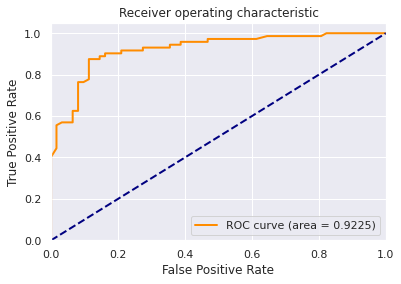

In [27]:
produce_roc([final_clf], x_sm_test, y_sm_test)